# Prepare environment

In [110]:
!source .venv/bin/activate

# Imports

In [111]:
import influxdb_client, os, time
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS
import numpy as np
import pandas as pd
import mlflow
from mlflow.models import infer_signature, set_signature
import mlflow.keras
import yaml
from pickle import dump
import math
import os
import shutil
import matplotlib.pyplot as plt 
from datetime import datetime, timedelta

with open('Presences_keras.yaml', 'r') as file:
    variables = yaml.safe_load(file)

print(f"{variables}")


{'influx_db': {'url': 'https://influxdb.ap-home', 'org': 'openhab', 'token': 'U3b0bON--ptBSPLxXySbF5in5K0wxAwdmBv1J6tR-lFAEr6uW0wRqAWmo7elPMJYmmoE1tBQjFC3o0twEJfXFg=='}, 'mlflow': {'url': 'https://mlflow.ap-home'}, 'data': ['aymeric', 'joanne', 'time_since_last_interaction', 'in_bed', 'presence', 'presence_override', 'in_bed_override', 'working_from_home', 'dining_room_occupancy', 'corridor_occupancy', 'living_room_occupancy', 'master_bedroom_occupancy', 'basement_occupancy', 'deck_occupancy', 'sun:elevation', 'dimmer', 'dimmer_main', 'dimmer_fireplace', 'living_room_tv', 'fan_and_light_switch_main_2', 'fan_and_light_switch_2', 'plug3', 'room_occupation', 'openings', 'ha_started', 'presence_simulation', 'time_since_last_interactionate_bedtime', 'people', 'time_since_last_interaction_living_room', 'multisensor_illuminance', 'time_since_last_interaction_dining_room', 'multisensor_home_security_motion_detection', 'dining_room_motion', 'dining_room_multi_sensor_lux'], 'features': ['people'

# Load data

In [112]:
client = influxdb_client.InfluxDBClient(
    url=variables["influx_db"]["url"],
    token=variables["influx_db"]["token"],
    org=variables["influx_db"]["org"],
    verify_ssl=False,
    timeout=180000)

query_api = client.query_api()

# |> range(start: 2024-02-20T17:00:00Z)
start_time = "2024-03-23T00:00:00Z"
query_start = datetime.strptime(start_time, "%Y-%m-%dT%H:%M:%SZ") - timedelta(days=5) 

base_query = """
        from(bucket: "homeassistant")
            |> range(start: )
            |> filter(fn: (r) => r["entity_id"] == "entity_name")
            |> filter(fn: (r) => r["_field"] == "value")
            |> fill(usePrevious: true)
            |> drop(columns: ["result", "table", "_start", "_stop", "_field", "source","domain","_measurement", "friendly_name"])
            |> pivot(rowKey: ["_time"], columnKey: ["entity_id"], valueColumn: "_value")
            |> yield(name: "last")"""
base_query = base_query.replace("start: ", f'start: {datetime.strftime(query_start, "%Y-%m-%dT%H:%M:%SZ")}')
for nb, entity in enumerate(variables["data"]):
    print(entity)
    entity = entity.split(":")
    query = base_query.replace("entity_name", entity[0], 1)
    if len(entity)> 1 and {entity[1]} != "":
        query = query.replace('r["_field"] == "value"', f'r["_field"] == "{entity[1]}"')
        query = query.replace('columnKey: ["entity_id"]', f'columnKey: ["_field"]')
        query = query.replace(
            'drop(columns: ["result", "table", "_start", "_stop", "_field", "source","domain","_measurement", "friendly_name"])',
            'drop(columns: ["result", "table", "_start", "_stop", "entity_id", "source","domain","_measurement", "friendly_name"])'
        )
    if len(entity)> 2 and {entity[2]} != "":
       query = query.replace('fn: last,', f'fn: {entity[2]},')
    # print(query)
    df = query_api.query_data_frame(query, org=variables["influx_db"]["org"])
    print(df.head())
    try:
        df.set_index('_time', inplace=True)
        df.drop(["result", "table"], axis=1, inplace=True)
        if nb == 0:
            full_df = df.copy()
        else:
            full_df = full_df.join(df,on="_time", how='outer')
    except KeyError:
        print(f"{entity[1]} was not found")
        if len(entity)> 2:
            full_df[entity[1]] =  entity[2]
        else: 
            full_df[entity[1]] = np.nan
full_df.head()

aymeric


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  aymeric
0   last      0 2024-03-18 00:01:35.907823+00:00      1.0
1   last      0 2024-03-18 00:01:49.182806+00:00      1.0
2   last      0 2024-03-18 00:03:36.114711+00:00      1.0
3   last      0 2024-03-18 00:03:49.208323+00:00      1.0
4   last      0 2024-03-18 00:07:35.879536+00:00      1.0
joanne


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  joanne
0   last      0 2024-03-18 00:01:35.907610+00:00     1.0
1   last      0 2024-03-18 00:01:49.183208+00:00     1.0
2   last      0 2024-03-18 00:03:36.114452+00:00     1.0
3   last      0 2024-03-18 00:03:49.208644+00:00     1.0
4   last      0 2024-03-18 00:07:35.879370+00:00     1.0
time_since_last_interaction


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  time_since_last_interaction
0   last      0 2024-03-18 00:00:00.252002+00:00                         11.0
1   last      0 2024-03-18 00:00:49.563534+00:00                          0.0
2   last      0 2024-03-18 00:01:00.252786+00:00                         11.0
3   last      0 2024-03-18 00:01:00.496958+00:00                          0.0
4   last      0 2024-03-18 00:02:00.251832+00:00                         11.0
in_bed
  result  table                            _time  in_bed
0   last      0 2024-03-18 05:10:42.865482+00:00     1.0
1   last      0 2024-03-18 11:21:16.062103+00:00     0.0
2   last      0 2024-03-18 23:54:56.608436+00:00     0.0
3   last      0 2024-03-19 03:25:34.696488+00:00     1.0
4   last      0 2024-03-19 10:26:17.228242+00:00     0.0


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


presence
  result  table                            _time  presence
0   last      0 2024-03-18 12:55:11.671162+00:00       0.0
1   last      0 2024-03-18 15:14:51.412697+00:00       1.0
2   last      0 2024-03-18 16:02:40.164030+00:00       0.0
3   last      0 2024-03-18 20:05:52.346931+00:00       1.0
4   last      0 2024-03-18 23:54:56.606397+00:00       1.0
presence_override


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  presence_override
0   last      0 2024-03-18 23:54:51.357374+00:00                0.0
1   last      0 2024-03-20 01:39:49.446293+00:00                0.0
2   last      0 2024-03-20 02:05:24.396575+00:00                0.0
3   last      0 2024-03-21 01:57:30.317946+00:00                0.0
4   last      0 2024-03-21 03:05:42.108915+00:00                0.0
in_bed_override
  result  table                            _time  in_bed_override
0   last      0 2024-03-18 23:54:51.357771+00:00              0.0
1   last      0 2024-03-20 01:39:49.446663+00:00              0.0
2   last      0 2024-03-20 02:05:24.397113+00:00              0.0
3   last      0 2024-03-21 01:57:30.318597+00:00              0.0
4   last      0 2024-03-21 03:05:42.110753+00:00              0.0


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


working_from_home
  result  table                            _time  working_from_home
0   last      0 2024-03-18 23:54:51.357840+00:00                0.0
1   last      0 2024-03-20 01:39:49.446725+00:00                0.0
2   last      0 2024-03-20 02:05:24.397217+00:00                0.0
3   last      0 2024-03-21 01:57:30.318708+00:00                0.0
4   last      0 2024-03-21 03:05:42.110826+00:00                0.0
dining_room_occupancy


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  dining_room_occupancy
0   last      0 2024-03-18 02:56:48.852199+00:00                    0.0
1   last      0 2024-03-18 03:05:16.285252+00:00                    1.0
2   last      0 2024-03-18 03:11:36.978666+00:00                    0.0
3   last      0 2024-03-18 03:24:14.909343+00:00                    1.0
4   last      0 2024-03-18 03:30:41.375024+00:00                    0.0
corridor_occupancy


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  corridor_occupancy
0   last      0 2024-03-18 00:12:48.604341+00:00                 0.0
1   last      0 2024-03-18 00:12:54.446287+00:00                 1.0
2   last      0 2024-03-18 01:11:56.707669+00:00                 0.0
3   last      0 2024-03-18 01:38:17.877663+00:00                 1.0
4   last      0 2024-03-18 01:49:38.713213+00:00                 0.0
living_room_occupancy


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  living_room_occupancy
0   last      0 2024-03-18 04:42:52.125834+00:00                    1.0
1   last      0 2024-03-18 04:42:52.126169+00:00                    1.0
2   last      0 2024-03-18 04:42:52.126412+00:00                    1.0
3   last      0 2024-03-18 04:42:52.127056+00:00                    1.0
4   last      0 2024-03-18 04:45:34.002635+00:00                    1.0
master_bedroom_occupancy


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  master_bedroom_occupancy
0   last      0 2024-03-18 00:22:57.172762+00:00                       1.0
1   last      0 2024-03-18 00:22:57.172971+00:00                       1.0
2   last      0 2024-03-18 00:22:57.173190+00:00                       1.0
3   last      0 2024-03-18 00:22:57.173891+00:00                       1.0
4   last      0 2024-03-18 00:24:29.435750+00:00                       1.0
basement_occupancy


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  basement_occupancy
0   last      0 2024-03-18 20:51:36.134896+00:00                 1.0
1   last      0 2024-03-18 21:11:16.728809+00:00                 0.0
2   last      0 2024-03-18 21:12:31.544347+00:00                 1.0
3   last      0 2024-03-18 21:55:50.987371+00:00                 0.0
4   last      0 2024-03-20 00:23:24.125878+00:00                 1.0
deck_occupancy


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  deck_occupancy
0   last      0 2024-03-18 12:36:06.716675+00:00             1.0
1   last      0 2024-03-18 12:44:51.302329+00:00             0.0
2   last      0 2024-03-18 23:33:46.759455+00:00             1.0
3   last      0 2024-03-18 23:38:56.337253+00:00             0.0
4   last      0 2024-03-19 22:00:11.524054+00:00             1.0
sun:elevation


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  elevation
0   last      0 2024-03-18 00:03:01.346691+00:00      -4.41
1   last      0 2024-03-18 00:07:01.347466+00:00      -5.16
2   last      0 2024-03-18 00:11:33.105008+00:00      -6.00
3   last      0 2024-03-18 00:19:33.105672+00:00      -7.48
4   last      0 2024-03-18 00:27:33.107852+00:00      -8.96
dimmer
  result  table                            _time  dimmer
0   last      0 2024-03-18 00:11:57.773724+00:00     1.0
1   last      0 2024-03-18 00:11:59.213377+00:00     1.0
2   last      0 2024-03-18 02:56:49.657517+00:00     1.0
3   last      0 2024-03-18 02:57:48.912665+00:00     0.0
4   last      0 2024-03-18 04:41:11.816739+00:00     0.0


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


dimmer_main
  result  table                            _time  dimmer_main
0   last      0 2024-03-18 01:41:35.571414+00:00          1.0
1   last      0 2024-03-18 01:41:37.599714+00:00          1.0
2   last      0 2024-03-18 03:58:07.606565+00:00          0.0
3   last      0 2024-03-18 03:58:20.350773+00:00          1.0
4   last      0 2024-03-18 04:39:35.636080+00:00          0.0


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


dimmer_fireplace
  result  table                            _time  dimmer_fireplace
0   last      0 2024-03-18 01:41:35.232197+00:00               1.0
1   last      0 2024-03-18 01:41:37.379095+00:00               1.0
2   last      0 2024-03-18 03:58:07.685122+00:00               0.0
3   last      0 2024-03-18 03:58:20.110796+00:00               1.0
4   last      0 2024-03-18 04:39:35.517579+00:00               0.0


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


living_room_tv
  result  table                            _time  living_room_tv
0   last      0 2024-03-18 04:40:02.036299+00:00             0.0
1   last      0 2024-03-18 22:15:40.705525+00:00             1.0
2   last      0 2024-03-18 23:54:51.357636+00:00             1.0
3   last      0 2024-03-19 01:07:58.050434+00:00             0.0
4   last      0 2024-03-19 10:31:49.676795+00:00             1.0


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


fan_and_light_switch_main_2
  result  table                            _time  fan_and_light_switch_main_2
0   last      0 2024-03-18 00:31:55.480480+00:00                          1.0
1   last      0 2024-03-18 00:31:57.743940+00:00                          1.0
2   last      0 2024-03-18 03:50:41.849968+00:00                          1.0
3   last      0 2024-03-18 03:51:41.850248+00:00                          0.0
4   last      0 2024-03-18 04:21:11.027926+00:00                          1.0


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


fan_and_light_switch_2
  result  table                            _time  fan_and_light_switch_2
0   last      0 2024-03-18 04:41:11.819815+00:00                     0.0
1   last      0 2024-03-18 04:42:25.710623+00:00                     0.0
2   last      0 2024-03-18 23:54:56.751995+00:00                     0.0
3   last      0 2024-03-20 01:39:56.107823+00:00                     0.0
4   last      0 2024-03-20 02:05:37.653201+00:00                     0.0
plug3


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  plug3
0   last      0 2024-03-18 03:50:41.802985+00:00    0.0
1   last      0 2024-03-18 11:33:58.370351+00:00    1.0
2   last      0 2024-03-18 12:55:12.106329+00:00    0.0
3   last      0 2024-03-18 15:15:04.364163+00:00    1.0
4   last      0 2024-03-18 16:02:40.581463+00:00    0.0
room_occupation
  result  table                            _time  room_occupation
0   last      0 2024-03-18 02:57:19.671811+00:00              0.0
1   last      0 2024-03-18 03:05:16.296523+00:00              1.0
2   last      0 2024-03-18 03:12:14.985593+00:00              0.0
3   last      0 2024-03-18 03:24:14.917177+00:00              1.0
4   last      0 2024-03-18 03:31:11.395894+00:00              0.0


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


openings
  result  table                            _time  openings
0   last      0 2024-03-18 01:56:11.168061+00:00       1.0
1   last      0 2024-03-18 01:56:22.370322+00:00       0.0
2   last      0 2024-03-18 01:56:25.489539+00:00       1.0
3   last      0 2024-03-18 01:56:28.462193+00:00       0.0
4   last      0 2024-03-18 01:58:51.325551+00:00       1.0


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


ha_started
  result  table                            _time  ha_started
0   last      0 2024-03-18 23:54:31.193151+00:00         0.0
1   last      0 2024-03-18 23:54:51.357906+00:00         0.0
2   last      0 2024-03-18 23:56:14.354241+00:00         1.0
3   last      0 2024-03-20 01:39:27.779710+00:00         0.0
4   last      0 2024-03-20 01:39:49.446787+00:00         0.0
presence_simulation


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  presence_simulation
0   last      0 2024-03-18 20:02:41.770573+00:00                  1.0
1   last      0 2024-03-18 20:02:41.791780+00:00                  1.0
2   last      0 2024-03-18 20:02:44.902317+00:00                  1.0
3   last      0 2024-03-18 20:05:52.558792+00:00                  0.0
4   last      0 2024-03-18 20:05:52.600410+00:00                  0.0
time_since_last_interactionate_bedtime


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  \
0   last      0 2024-03-18 00:00:00.056719+00:00   
1   last      0 2024-03-18 00:01:00.056146+00:00   
2   last      0 2024-03-18 00:02:00.056451+00:00   
3   last      0 2024-03-18 00:03:00.056506+00:00   
4   last      0 2024-03-18 00:04:00.056157+00:00   

   time_since_last_interactionate_bedtime  
0                                   350.0  
1                                   410.0  
2                                   470.0  
3                                   530.0  
4                                   590.0  
people
  result  table                            _time  people
0   last      0 2024-03-18 12:44:50.936935+00:00     0.0
1   last      0 2024-03-18 15:14:51.411564+00:00     1.0
2   last      0 2024-03-18 20:05:52.345860+00:00     1.0
3   last      0 2024-03-18 23:54:56.606151+00:00     1.0
4   last      0 2024-03-19 12:39:31.708832+00:00     0.0


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


time_since_last_interaction_living_room
  result  table                            _time  \
0   last      0 2024-03-21 03:42:33.499880+00:00   
1   last      0 2024-03-21 03:43:00.324806+00:00   
2   last      0 2024-03-21 03:44:12.308942+00:00   
3   last      0 2024-03-21 03:44:24.541386+00:00   
4   last      0 2024-03-21 03:45:00.396364+00:00   

   time_since_last_interaction_living_room  
0                                    384.0  
1                                    411.0  
2                                    483.0  
3                                      0.0  
4                                     36.0  
multisensor_illuminance


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  multisensor_illuminance
0   last      0 2024-03-18 00:03:06.588549+00:00                      0.0
1   last      0 2024-03-18 00:08:07.190300+00:00                      0.0
2   last      0 2024-03-18 00:13:07.789981+00:00                      0.0
3   last      0 2024-03-18 00:18:08.393372+00:00                      0.0
4   last      0 2024-03-18 00:18:08.432666+00:00                      0.0
time_since_last_interaction_dining_room


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


  result  table                            _time  \
0   last      0 2024-03-21 03:42:33.503338+00:00   
1   last      0 2024-03-21 03:43:00.243993+00:00   
2   last      0 2024-03-21 03:44:12.309521+00:00   
3   last      0 2024-03-21 03:45:00.274751+00:00   
4   last      0 2024-03-21 03:46:00.274183+00:00   

   time_since_last_interaction_dining_room  
0                                  85353.0  
1                                  85380.0  
2                                  85452.0  
3                                  85500.0  
4                                  85560.0  
multisensor_home_security_motion_detection
  result  table                            _time  \
0   last      0 2024-03-18 04:41:11.845705+00:00   
1   last      0 2024-03-18 04:42:25.748097+00:00   
2   last      0 2024-03-18 04:42:52.120932+00:00   
3   last      0 2024-03-18 04:44:33.996038+00:00   
4   last      0 2024-03-18 11:50:52.584935+00:00   

   multisensor_home_security_motion_detection  
0            

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


dining_room_motion
  result  table                            _time  dining_room_motion
0   last      0 2024-03-18 00:36:11.281241+00:00                 0.0
1   last      0 2024-03-18 00:37:14.507796+00:00                 1.0
2   last      0 2024-03-18 00:46:29.953513+00:00                 0.0
3   last      0 2024-03-18 00:47:04.862708+00:00                 1.0
4   last      0 2024-03-18 00:48:21.923985+00:00                 0.0


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


dining_room_multi_sensor_lux
  result  table                            _time  dining_room_multi_sensor_lux
0   last      0 2024-03-18 00:20:46.876491+00:00                           1.0
1   last      0 2024-03-18 00:32:49.876713+00:00                           0.0
2   last      0 2024-03-18 13:50:16.216896+00:00                           1.0
3   last      0 2024-03-18 14:47:00.344405+00:00                           2.0
4   last      0 2024-03-18 15:56:39.202077+00:00                           3.0


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'influxdb.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,_time,aymeric,joanne,time_since_last_interaction,in_bed,presence,presence_override,in_bed_override,working_from_home,dining_room_occupancy,...,ha_started,presence_simulation,time_since_last_interactionate_bedtime,people,time_since_last_interaction_living_room,multisensor_illuminance,time_since_last_interaction_dining_room,multisensor_home_security_motion_detection,dining_room_motion,dining_room_multi_sensor_lux
NaT,2024-03-18 00:00:00.056719+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,350.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,2024-03-18 00:00:00.252002+00:00,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,2024-03-18 00:00:49.563534+00:00,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,2024-03-18 00:01:00.056146+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,410.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,2024-03-18 00:01:00.252786+00:00,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Prepare data

In [113]:
print(full_df.shape)
print(full_df.head())
feature_names = variables["features"]

for feature in variables["numeric_features"]:
    full_df[feature] = pd.Series.interpolate(full_df[feature])

full_df.ffill(inplace=True)
full_df["home_status"] = full_df["in_bed"] + full_df["presence"]
full_df = full_df[full_df['ha_started']==1]
full_df.reset_index(inplace=True)
full_df = full_df[full_df['_time']> start_time]
new_df = full_df[variables["features"] + variables["targets"]].copy()
print(new_df.head())
new_df.dropna(inplace=True)
new_df.reset_index(inplace=True)
new_df.drop_duplicates(feature_names, inplace=True, ignore_index=True)
print(new_df.dtypes)


print(new_df.shape)

target = new_df[variables["targets"]]
numeric_features = new_df[feature_names]
numeric_features.head(20)



(204976, 35)
                               _time  aymeric  joanne  \
NaT 2024-03-18 00:00:00.056719+00:00      NaN     NaN   
NaT 2024-03-18 00:00:00.252002+00:00      NaN     NaN   
NaT 2024-03-18 00:00:49.563534+00:00      NaN     NaN   
NaT 2024-03-18 00:01:00.056146+00:00      NaN     NaN   
NaT 2024-03-18 00:01:00.252786+00:00      NaN     NaN   

     time_since_last_interaction  in_bed  presence  presence_override  \
NaT                          NaN     NaN       NaN                NaN   
NaT                         11.0     NaN       NaN                NaN   
NaT                          0.0     NaN       NaN                NaN   
NaT                          NaN     NaN       NaN                NaN   
NaT                         11.0     NaN       NaN                NaN   

     in_bed_override  working_from_home  dining_room_occupancy  ...  \
NaT              NaN                NaN                    NaN  ...   
NaT              NaN                NaN                    NaN 

,people,time_since_last_interaction,time_since_last_interactionate_bedtime,working_from_home,presence_override,in_bed_override,time_since_last_interaction_dining_room,dining_room_motion,dining_room_multi_sensor_lux,corridor_occupancy,time_since_last_interaction_living_room,multisensor_home_security_motion_detection,multisensor_illuminance,master_bedroom_occupancy,basement_occupancy,deck_occupancy,elevation,presence_simulation
0,1.0,9.000000,452.0,0.0,0.0,0.0,2767.0,1.0,1.532022,1.0,447.0,0.0,0.0,0.0,0.0,0.0,-2.818372,0.0
1,1.0,7.200000,457.0,0.0,0.0,0.0,2772.0,1.0,1.531014,1.0,452.0,0.0,0.0,0.0,0.0,0.0,-2.836279,0.0
2,1.0,5.400000,467.0,0.0,0.0,0.0,2777.0,1.0,1.530005,1.0,457.0,0.0,0.0,0.0,0.0,0.0,-2.854186,0.0
3,1.0,3.600000,477.0,0.0,0.0,0.0,2782.0,1.0,1.528996,1.0,467.0,0.0,0.0,0.0,0.0,0.0,-2.872093,0.0
4,1.0,1.800000,487.0,0.0,0.0,0.0,2792.0,1.0,1.527988,1.0,477.0,0.0,0.0,0.0,0.0,0.0,-2.890000,0.0
5,1.0,0.000000,497.0,0.0,0.0,0.0,2802.0,1.0,1.526979,1.0,487.0,0.0,0.0,0.0,0.0,0.0,-2.915333,0.0
6,1.0,1.000000,507.0,0.0,0.0,0.0,2812.0,1.0,1.525971,1.0,497.0,0.0,0.0,0.0,0.0,0.0,-2.940667,0.0
7,1.0,13.000000,517.0,0.0,0.0,0.0,2822.0,1.0,1.524962,1.0,507.0,0.0,0.0,0.0,0.0,0.0,-2.966000,0.0
8,1.0,25.000000,529.0,0.0,0.0,0.0,2832.0,1.0,1.523954,1.0,517.0,0.0,0.0,0.0,0.0,0.0,-2.991333,0.0
9,1.0,37.000000,541.0,0.0,0.0,0.0,2842.0,1.0,1.522945,1.0,529.0,0.0,0.0,0.0,0.0,0.0,-3.016667,0.0


# mlflow setup

In [114]:
os.environ["MLFLOW_TRACKING_INSECURE_TLS"] = "true"
os.environ["MLFLOW_TRACKING_URI"]="http://192.168.0.2:5051"
mlflow.set_tracking_uri(uri="http://192.168.0.2:5051")
mlflow.set_tracking_uri(uri=variables["mlflow"]["url"])
mlflow.set_experiment("Presence detection generalization keras.")

mlflow.autolog()

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Conv1D, MaxPooling1D, Normalization, Dropout, Reshape, Conv2D, MaxPooling2D, Input
from tensorflow.keras.metrics import F1Score, Recall, Precision


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
2024/04/05 01:33:16 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2024/04/05 01:33:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


2024/04/05 01:33:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/04/05 01:33:16 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2024/04/05 01:33:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.


# Data transformation

In [115]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    numeric_features, target, test_size=0.2, random_state=42
)
print(X_train.shape)
print(X_test.shape)

(116963, 18)
(29241, 18)


# Model, pipeline setup and fit

In [121]:
# Define input shape
input_shape = (X_train.values.shape[1],) 

mean = np.mean(X_train.values)
variance = np.var(X_train.values)
print(f"mean: {mean}")
print(f"variance: {variance}")

mlflow.set_tag("type", "CNN", synchronous=False)

# Define the model
model = Sequential()
model.add(Input(shape=input_shape))
model.add(Normalization(mean=mean, variance=variance, axis=None))
model.add(Reshape((3,6)))
model.add(LSTM(512, return_sequences=True))
mlflow.set_tag("type", "RNN", synchronous=False)
# model.add(Reshape((3,3,2)))
# model.add(Conv2D(256, (1,1), activation='relu'))
# model.add(MaxPooling2D(1,1))
# model.add(Conv2D(256, (1,1), activation='relu'))
# model.add(MaxPooling2D(3,3))
# mlflow.set_tag("type", "CNN", synchronous=False)

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='sigmoid'))
model.summary()
# model = Sequential([
#     Input(shape=input_shape),
#     Normalization(mean=mean, variance=variance, axis=None),
# ##############################    
#    Reshape((3,3,2)),
#    Conv2D(256, (1,1), activation='relu'),
#    MaxPooling2D(1,1),
#    Conv2D(256, (1,1), activation='relu'),
#    MaxPooling2D(3,3),
# #    mlflow.set_tag("type", "CNN", synchronous=False)
# ############################
#     # Reshape((3,6)),
#     # LSTM(512, input_shape=input_shape,  return_sequences=True),
# #    mlflow.set_tag("type", "RNN", synchronous=False)
# ############################
#     Flatten(),
#     Dense(64, activation='relu'),
#     Dropout(0.5),
#     Dense(32, activation='relu'),
#     Dropout(0.5),
#     Dense(16, activation='relu'),
#     Dropout(0.5),
#     Dense(9, kernel_initializer='normal', activation='sigmoid')  # 2 output targets
# ])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'binary_crossentropy'])


mean: 775.8406474119467
variance: 10834472.235617641


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_49                │ (None, 18)             │             0 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_49 (Reshape)            │ (None, 3, 3, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_97 (Conv2D)              │ (None, 3, 3, 256)      │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_98 (Conv2D)              │ (None, 3, 3, 256)      │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_90 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_35 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_102 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_103 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_104 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_140 (Dense)               │ (None, 9)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,769 (335.04 KB)

 Trainable params: 85,769 (335.04 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_49                │ (None, 18)             │             0 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_49 (Reshape)            │ (None, 3, 3, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_97 (Conv2D)              │ (None, 3, 3, 256)      │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_98 (Conv2D)              │ (None, 3, 3, 256)      │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_90 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_35 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_102 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_103 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_104 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_140 (Dense)               │ (None, 9)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,769 (335.04 KB)

 Trainable params: 85,769 (335.04 KB)

 Non-trainable params: 0 (0.00 B)

In [122]:
# Train the model
batch_size = 25
epochs = 125

history = model.fit(X_train.values, y_train.values, batch_size=batch_size, epochs=epochs, validation_split=0.2)

run_dict =  mlflow.last_active_run().to_dictionary() 
print(run_dict)

mlflow.end_run()

2024/04/05 02:04:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings"
2024/04/05 02:04:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings"
2024/04/05 02:04:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpoo

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Epoch 1/125
3743/3743 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.6595 - binary_crossentropy: 0.4156 - loss: 0.4156 - val_accuracy: 0.7542 - val_binary_crossentropy: 0.3072 - val_loss: 0.3072
Epoch 2/125
3743/3743 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7452 - binary_crossentropy: 0.3241 - loss: 0.3241 - val_accuracy: 0.7615 - val_binary_crossentropy: 0.3014 - val_loss: 0.3013
Epoch 3/125
3743/3743 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7543 - binary_crossentropy: 0.3177 - loss: 0.3177 - val_accuracy: 0.7637 - val_binary_crossentropy: 0.2987 - val_loss: 0.2987
Epoch 4/125
3743/3743 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7526 - binary_crossentropy: 0.3116 - loss: 0.3116 - val_accuracy: 0.7566 - val_binary_crossentropy: 0.2965 - val_loss: 0.2965
Epoch 5/125
3743/3743 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7603 - binary_crossentropy: 0.3112 - loss: 0.3112 - val_accuracy: 0.7685 - val_binary_crossentropy: 0.2955 - val_loss: 0.2954
Epoch 6/125
3743/3743 ━━

2024/04/05 02:23:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings"


{'info': {'artifact_uri': '/mnt/nfs/mlflow/14/03712d181f73436e90a5ab4340b0bfd9/artifacts', 'end_time': None, 'experiment_id': '14', 'lifecycle_stage': 'active', 'run_id': '03712d181f73436e90a5ab4340b0bfd9', 'run_name': 'invincible-dove-663', 'run_uuid': '03712d181f73436e90a5ab4340b0bfd9', 'start_time': 1712282697476, 'status': 'RUNNING', 'user_id': 'vscode'}, 'data': {'metrics': {}, 'params': {}, 'tags': {'mlflow.user': 'vscode', 'mlflow.source.name': '/workspaces/python/.venv/lib/python3.11/site-packages/ipykernel_launcher.py', 'mlflow.source.type': 'LOCAL', 'mlflow.runName': 'invincible-dove-663'}}}


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [123]:
run_dict =  mlflow.last_active_run().to_dictionary() 
print(run_dict)
signature = infer_signature(numeric_features, model.predict(numeric_features))
set_signature(f"runs:/{run_dict['info']['run_id']}/model", signature)

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


{'info': {'artifact_uri': '/mnt/nfs/mlflow/14/03712d181f73436e90a5ab4340b0bfd9/artifacts', 'end_time': 1712283802354, 'experiment_id': '14', 'lifecycle_stage': 'active', 'run_id': '03712d181f73436e90a5ab4340b0bfd9', 'run_name': 'invincible-dove-663', 'run_uuid': '03712d181f73436e90a5ab4340b0bfd9', 'start_time': 1712282697476, 'status': 'FINISHED', 'user_id': 'vscode'}, 'data': {'metrics': {'accuracy': 0.7579993605613708, 'binary_crossentropy': 0.300632119178772, 'loss': 0.30063509941101074, 'validation_accuracy': 0.7539862394332886, 'validation_binary_crossentropy': 0.28731462359428406, 'validation_loss': 0.28728944063186646, 'val_accuracy': 0.7539862394332886, 'val_binary_crossentropy': 0.28731462359428406, 'val_loss': 0.28728944063186646}, 'params': {'batch_size': '25', 'class_weight': 'None', 'epochs': '125', 'initial_epoch': '0', 'optimizer_amsgrad': 'False', 'optimizer_beta_1': '0.9', 'optimizer_beta_2': '0.999', 'optimizer_clipnorm': 'None', 'optimizer_clipvalue': 'None', 'optimi

/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


dict_keys(['accuracy', 'binary_crossentropy', 'loss', 'val_accuracy', 'val_binary_crossentropy', 'val_loss'])


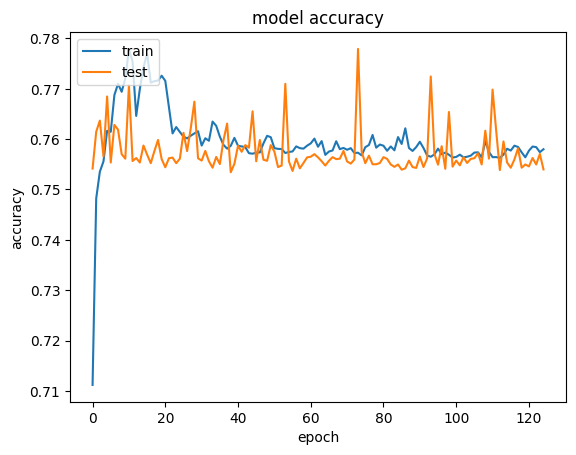

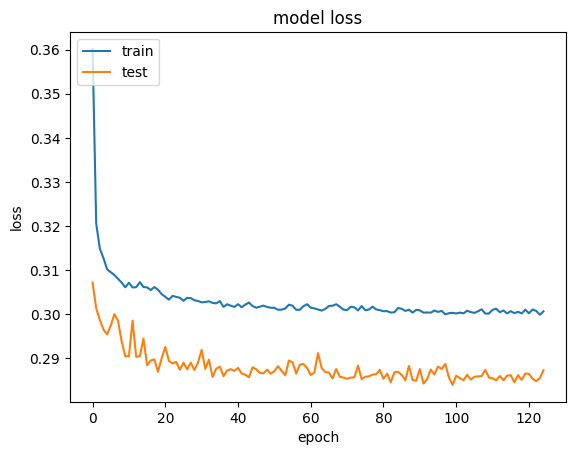

In [124]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

mlflow.end_run()

914/914 ━━━━━━━━━━━━━━━━━━━━ 1s 899us/step
(29241, 9)
[8.7364569e-02 4.7539937e-01 1.5091995e-03 8.1425179e-11 2.6812206e-03
 1.2412839e-04 8.5946667e-08 1.1297216e-02 3.1217205e-04]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
(29241, 9)
0.2978231852344523
[0.82626539 0.99006907 0.83712121 0.026953   0.         0.
 0.         0.         0.        ]
[[[22662   169]
  [  974  5436]]

 [[ 2456   124]
  [  142 26519]]

 [[11289  1308]
  [ 1616 15028]]

 [[20114    56]
  [ 8825   246]]

 [[22183     0]
  [ 7058     0]]

 [[23499     0]
  [ 5742     0]]

 [[23059     0]
  [ 6182     0]]

 [[20150     0]
  [ 9091     0]]

 [[28866     0]
  [  375     0]]]


/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mlflow.ap-home'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/workspaces/python/.venv/lib

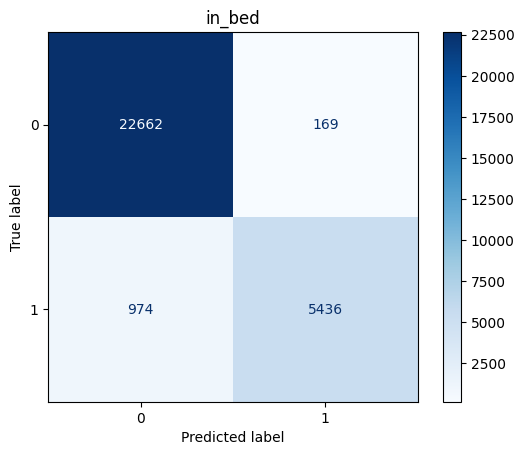

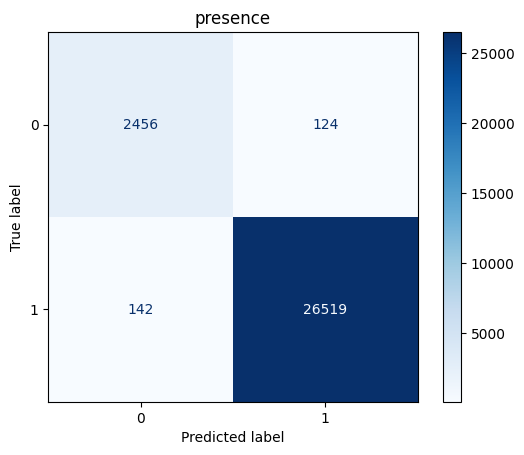

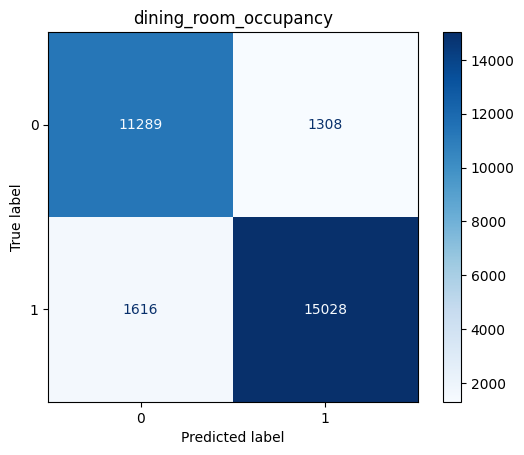

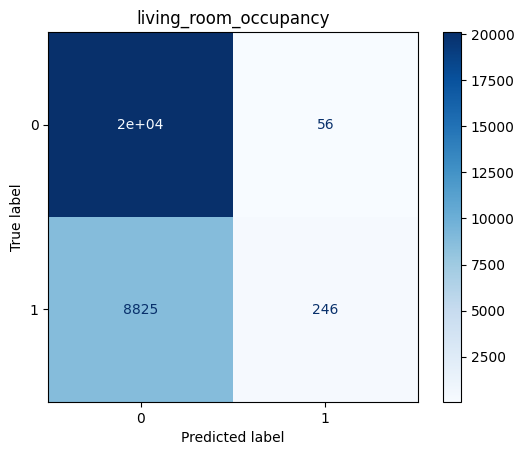

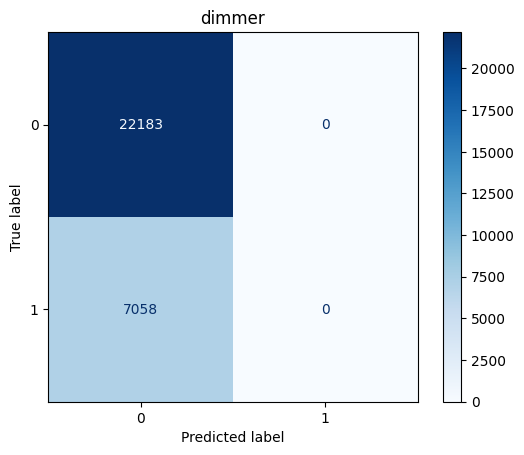

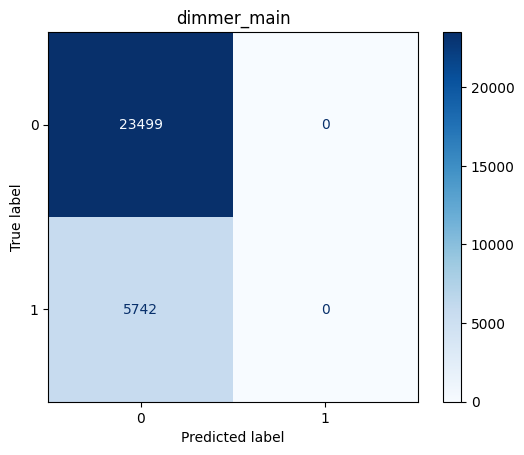

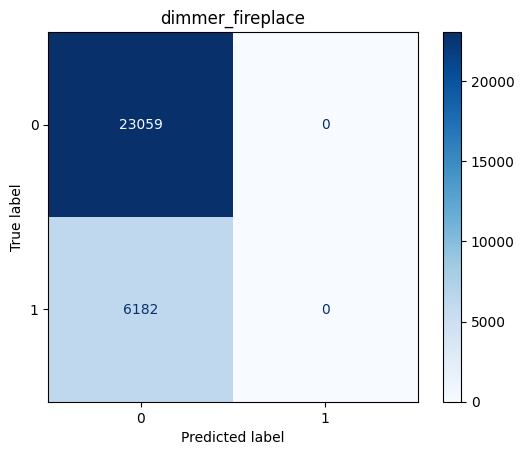

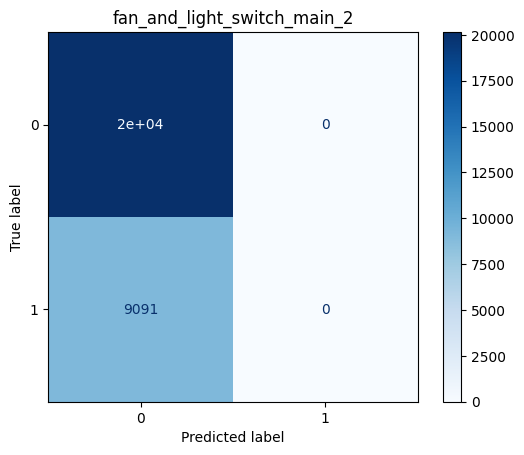

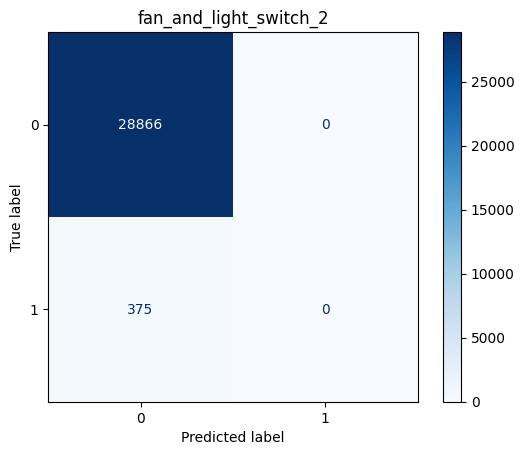

In [125]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, jaccard_score
metrics_dict = {}
y_pred = model.predict(X_test)
print(y_pred.shape)
print(y_pred[0])
for idx, array in enumerate(y_pred):
    # print(y_pred[idx].shape)
    y_pred[idx] = (y_pred[idx]>0.7).astype(int)

print(y_pred[0])

print(y_pred.shape)

metrics_dict["jaccard score macro"] = jaccard_score(y_test.values, y_pred, average='macro')
print(metrics_dict["jaccard score macro"] )

jaccard_score_array = jaccard_score(y_test.values, y_pred, average=None)
print(jaccard_score_array)
cm = multilabel_confusion_matrix(y_test, y_pred)
cm_dict = {}
jaccard_score_dict = {}
for idx, target in enumerate(variables["targets"]):
    cm_dict[target] = cm[idx]
    jaccard_score_dict[target] = jaccard_score_array[idx]
    cm_disp = ConfusionMatrixDisplay(cm_dict[target])
    cm_disp.plot(cmap=plt.cm.Blues,)
    plt.title(f"{target}")
    plt.savefig(f"test_confusion_matrix_{target}.png")
    shutil.copy(f"test_confusion_matrix_{target}.png", f"/mnt/nfs/mlflow/{run_dict['info']['experiment_id']}/{run_dict['info']['run_id']}/artifacts/")

print(cm)
mlflow.log_metrics(metrics_dict, run_id=f"{run_dict['info']['run_id']}")
mlflow.log_table(cm_dict, artifact_file="confusion_matrix", run_id=f"{run_dict['info']['run_id']}")
mlflow.log_table(jaccard_score_dict, artifact_file="jaccard_score", run_id=f"{run_dict['info']['run_id']}")

with mlflow.start_run() as run:
    mlflow.autolog()
    import autokeras as ak
    os.environ["MLFLOW_TRACKING_INSECURE_TLS"] = "true"
    mlflow.set_tracking_uri(uri=variables["mlflow"]["url"])
    mlflow.set_experiment("Presence detection generalization keras.")
    # define the search
    search = ak.AutoModel(
        inputs=[ak.Input()],
        outputs=[
            ak.ClassificationHead(
                loss="binary_crossentropy", metrics=["accuracy"]
            ),
        ],
    overwrite=True,
    max_trials=100,
    )
    # perform the search
    history = search.fit(x=numeric_features.values, y=target.values, validation_split=0.2,)

    accuracy, _ = search.evaluate(numeric_features.values, target.values, verbose=0)
    print('Accuracy: %.3f' % accuracy)

    # get the best performing model
    model = search.export_model()
    signature = infer_signature(numeric_features, model.predict(numeric_features))
    # summarize the loaded model
model.summary()

run_dict =  mlflow.last_active_run().to_dictionary() 
print(run_dict)
signature = infer_signature(numeric_features, model.predict(numeric_features))
set_signature(f"runs:/{run_dict['info']['run_id']}/model", signature)